# This short tutorial explains how to use the package pygme to build a self-consistent model with particles. 

The basis for this can be found in papers written in the 90's, namely:
Monnet et al. 1992
Emsellem et al. 1994
See Emsellem et al. 1999 on the modelling of NGC3115 for a more detailed example.

In [107]:
import numpy as np
import math
# pygme itself
import pygme
# the fitting for N 2Dimensional Gaussians
from pygme.fitting import fitn2dgauss
from pygme.fitting import fitGaussHermite
import matplotlib.pyplot as plt
# the warnings above can be ignored. This comes from an import of lmfit, which is by default not installed.
# Note: all the pygme code has been made compatible with python3 using *2to3*. A new version of pygme is being developed which is more pythonic and more robust, but this is written entirely from scratch.

# We import the module
from pygme.astroprofiles import sersic
# Import the module
from pygme.paramMGE import create_mge
# Importing the fitting routine
from pygme.fitting.fitn1dgauss import multi_1dgauss_mpfit

## Import the histogram functionalities
from pygme.pyhist import comp_losvd

# 1 - Setting up the Sersic Law

Now we are going to use the Sersic module to set up a luminosity profile


In [108]:
#Reproducible results:
np.random.seed(123)

In [109]:
# We first set up a sampling in radius (in parsec)
# From let's say 1 pc to about 10000 pc
rsamp = np.logspace(0.,4.,1001)
# now we get the profile itself - Re = 1.5kpc, rsamp goes to 10000pc, hence more than 6 Re
myprofile = sersic.SersicProfile(n=2, Ie=1.0, Re=1500.0, rsamp=rsamp)

/home/fraison/anaconda3/lib/python3.6/site-packages/pygme/astroprofiles/data/Abel_param.dat


Text(0, 0.5, 'Sersic law - projected profile [log10]')

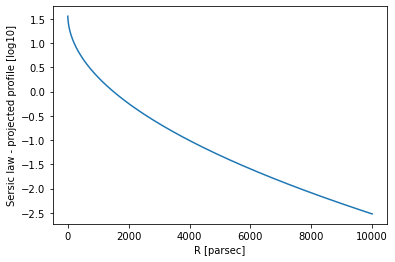

In [110]:
%matplotlib inline
plt.plot(myprofile.r, np.log10(myprofile.rhop))
plt.xlabel("R [parsec]")
plt.ylabel("Sersic law - projected profile [log10]")

# 2 - Fitting the profile¶

Fit this with a Multi-Gaussian Expansion (MGE) model.


In [111]:
# Defining the maximum number of gaussians to approximate the profile.
nGauss = 14
# Importing the fitting routine
from pygme.fitting.fitn1dgauss import multi_1dgauss_mpfit
# Doing the fit
bestparSersic, mpfit_output, fitSersic = multi_1dgauss_mpfit(myprofile.r, myprofile.rhop, ngauss=nGauss)

------ Starting the minimisation -------
Chi2 =  0.10241031061549845
Chi2 =  0.014457705522483294
Chi2 =  0.013960011416424214
Chi2 =  0.013116020286641309
Chi2 =  0.011879688080248935
Chi2 =  0.01035274546013426
Chi2 =  0.008375630255044994
Chi2 =  0.005506317785426071
Chi2 =  0.002525236070531542
Chi2 =  0.0024249413173733506
Chi2 =  0.002273463318819753
Chi2 =  0.002089673739938614
Chi2 =  0.0018773803710555375
Chi2 =  0.0015509288592703467
Chi2 =  0.0010905577109238723
Chi2 =  0.0010779645718402913
Chi2 =  0.0010560260300138346
Chi2 =  0.0010179698655027427
Chi2 =  0.0009484926774048887
Chi2 =  0.0008332682654171192
Chi2 =  0.0006749804945130777
Chi2 =  0.0006712691346174558
Chi2 =  0.0006646284971902093
Chi2 =  0.0006520775176415595
Chi2 =  0.0006294205193113726
Chi2 =  0.0005917135398438146
Chi2 =  0.0005365074454162337
Chi2 =  0.0005336544853121585
Chi2 =  0.0005283126996912723
Chi2 =  0.0005186740215150374
Chi2 =  0.0005020962169265125
Chi2 =  0.00047532208324829853
Chi2 =  0.0

/home/fraison/anaconda3/lib/python3.6/site-packages/pygme/fitting/mpfit.py:2268: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if numpy.rank(rr) != 2:


In [112]:
#this one needs to be checked as it can become nonsense when there is no convergence
#if bad redo with one gaussian less
print(bestparSersic[-1,1], rsamp[-1]) # > rsamp[-1] ?

4885.631408105441 10000.0


Text(0, 0.5, 'log10($\\rho$)')

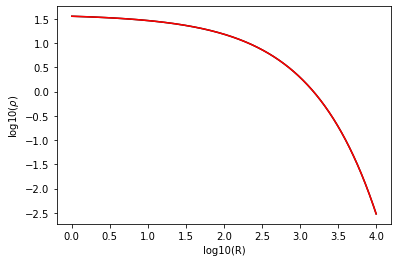

In [113]:
## Checking the quality of the fit by plotting in black the original profile and in red the fit
plt.clf()
plt.plot(np.log10(myprofile.r), np.log10(myprofile.rhop), 'k-')
plt.plot(np.log10(myprofile.r), np.log10(fitSersic), 'r-')
plt.xlabel('log10(R)')
plt.ylabel(r'log10($\rho$)')

The 2 curves match: the fit is very good, from 0.1pc to 6000 pc!

Let's visualise the residuals themselves in %:

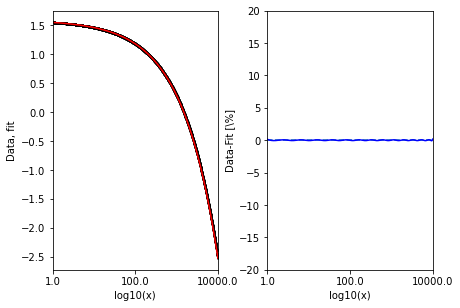

In [114]:
# Plotting the residuals in %
from pygme.fitting.examine_fit import plot_1dfit_residuals
plot_1dfit_residuals(myprofile.r, myprofile.rhop, fitSersic)

The residuals are much less than ~1% over the full range.

# 3- Transforming the MGE fit into an N-body 3D model

We have obtained the best fit Multi Gaussian parameters for a 1D Sersic profile. This can easily be converted into a 2D profile. Imagine the 1D profile is just the cut along the major-axis. Then a 2D Sersic galaxy would just have the same profile along the minor-axis, just rescaled with the axis ratio. So it is easy to turn this into a 2D projected model, which has a certain axis ratio (b/a) and has a Sersic profile along its major-axis.

So let's use the parameters of that MGE best fit model to 1- Set up a 2D MGE model, 2- deproject the MGE model in 3D so to obtain an MGE model with 3D Gaussians, and then 2- use that 3D MGE model to generate an N-body, self-consistently.

The first Step is to arrange the fitted parameters into arrays which can be used to create the model. We usually go through the saving of an ascii file where all parameters will be written up. This is also practical to change something by hand later on.

In [115]:
# Number of Gaussian for the N body
ngaussModel = bestparSersic.shape[0]
# We add some zeros (0) to add 1- the axis ratio 2- position angle 
parModel = np.hstack((bestparSersic, np.ones((ngaussModel,2))))
# Units - let's put the galaxy at 20 Mpc, hence ~97pc / arcsec
# we calculate the size of a segment when alpha = 1[arcsec] @ d= 20 [Mpc]
# size = d*tan(alpha) ~d*alpha
# 1 [deg]= 3600 [arcsec]
# alpha [rad]= pi/(180*3600) = pi/648000
# size= 20e6[pc] * pi/648000 = 96.96 pc
# then 1arcsec ~ 100[pc]


pc_per_arcsec_10Mpc = 10.* math.pi / 0.648 #=48.481368110  pc/arcsec = Distance_Mpc * Pi / 0.648
kpc3_to_pc3 = 1.e9
kpc_to_pc = 1.e3

# First column is the amplitude. We can change it with some factor to make the total mass that we want
# factor_luminosity is set arbitrarily here so that later we get something reasonable for the luminosity
# of the galaxy. Hence it can be changed in any way to get larger or smaller galaxies
factor_luminosity = 100.0 
parModel[:,0] *= factor_luminosity
# Transforming the sigmas (second column) into arcsec, as we did set up the radii in parsec initially
parModel[:,1] /= pc_per_arcsec_10Mpc
# Let's add some axis ratio - here let's decide it is b/a= 0.8 (ellipticity is 1-b/a = 0.2)
parModel[:,2] = 0.8


# We now create the MGE ascii file which will save the best fit parameters of the Model
# We only have "stars" but in principle we could add a model for the Dark Halo or the Gas

# THe parameters are:
#     NGauss = Number of Gaussians used for modelling [stars, gas, DM]
#     NPartGroup/NPartRealised = list of npart for groups specified, number of Particles per Group, and number of such particles "realised" 


# Do it - using 1 Million = 100000 particles
# The programme creates an ascii file "Sersic_firstmodel_08.mge" with the parameters of the projected and deprojected Gaussians
# Since we provide 2D Gaussians (with an axis ratio), the programme will deproject these in 3D too.
nstars = 10000
create_mge(outfilename="Sersic_firstmodel_check.mge", Gauss2D=parModel, NGauss=(ngaussModel,0,0), 
           overwrite=True, Distance=10., NGroup=1, NDynGroup=1, NPartGroup=(nstars,0,0), 
           NRealisedPartGroup=(nstars,0,0),  MBH=0.) #mnull mass for BH

WARNING with status 1 while Problem with Euler angles, will set the default = 0, 90, 0 = edge-on
Edge-on deprojection

Deprojected Model with inclination of 90.00
      #       Imax              Sigma       Qx        Qy
           Lsun/pc^2/arcsec     arcsec
3D-G  1    3.09461976e+03           0.02314   0.80000   0.80000
3D-G  2    1.63757231e+03           0.06082   0.80000   0.80000
3D-G  3    8.94777097e+02           0.14692   0.80000   0.80000
3D-G  4    4.92270298e+02           0.33101   0.80000   0.80000
3D-G  5    2.67643809e+02           0.70172   0.80000   0.80000
3D-G  6    1.41067235e+02           1.40831   0.80000   0.80000
3D-G  7    7.06128169e+01           2.68740   0.80000   0.80000
3D-G  8    3.28352607e+01           4.89229   0.80000   0.80000
3D-G  9    1.38579590e+01           8.52117   0.80000   0.80000
3D-G 10    5.18547631e+00          14.24380   0.80000   0.80000
3D-G 11    1.68280264e+00          22.96049   0.80000   0.80000
3D-G 12    4.61370708e-01          36

# 4- Use the model¶
We now have an ascii file with the right MGE parameters to use as a model. 

In [116]:
# Let's read the model. The output will provide some details of what it is
myMGE = pygme.MGE("Sersic_firstmodel_check.mge")
print("kRZ"+str(myMGE.kRZ))
print("kRTheta"+str(myMGE.kRTheta) )

The BetaEps vector (beta = FacBetaEps * Epsilon) is fixed to  
                    [0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6]
WARNING with status 1 while Both 3D and 2D Gaussians were found: 
WARNING with status 1 while We thus used the 2D Gaussians as a prior for the deprojection at 90.00 degrees
Edge-on deprojection

Deprojected Model with inclination of 90.00
      #       Imax              Sigma       Qx        Qy
           Lsun/pc^2/arcsec     arcsec
3D-G  1    3.09499214e+03           0.02314   0.80000   0.80000
3D-G  2    1.63757213e+03           0.06082   0.80000   0.80000
3D-G  3    8.94807007e+02           0.14692   0.80000   0.80000
3D-G  4    4.92273875e+02           0.33101   0.80000   0.80000
3D-G  5    2.67644720e+02           0.70172   0.80000   0.80000
3D-G  6    1.41067572e+02           1.40831   0.80000   0.80000
3D-G  7    7.06128133e+01           2.68740   0.80000   0.80000
3D-G  8    3.28352764e+01           4.89229   0.80000   0.80000
3D-G  9    1

In [117]:
# Let's now see some basic parameters

#this one needs can be checked if bestparSersic[-1,1]not checked 
#as it can become nonsense when there is no convergence
#if bad redo with one gaussian less
myMGE.Sig3Darc[-1]



# Like: total Mass (in Msun)
print(myMGE.TMGEMass/1.e9)

2.9258735496163673


This means ~ 10^10 Msun. The use of the normalisation factor on the Luminosity is actually important (we used a factor of 100, which means that the initial model was only 10^8 Lsun).

Important Note: when initialising the model, the Mass to Light ratio M/L is always 1 for all Gaussians. Hence the model is ~10^10 Msun and ~10^10 Lsun too 


## Visualisation
We can also visualise the model in 2D (projected) or in 3D (deprojected)

Text(0, 0.5, 'V circular [km/s]')

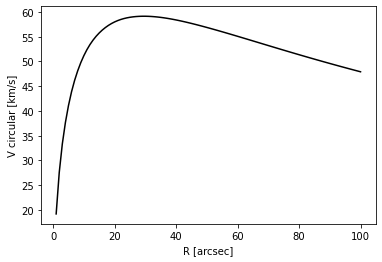

In [118]:
# Let's now compute a few things like
# The circular velocity profile of this model
R = np.linspace(1, 100, 100) # in arcsec
Vc = myMGE.Vcirc(R=R)
plt.plot(R, Vc, 'k-')
plt.xlabel("R [arcsec]")
plt.ylabel("V circular [km/s]")

## Realisation 

In [119]:
# This is the truncation radius (beyond = no particles)
maxR = 10000.0  # in parsec
# Making the N-body realisation
myMGE.realise_Nbody(mcut=maxR, TruncationMethod="Ellipsoid")

NStar = 10000 particles Realised over a total of 10000
NGas = 0 particles Realised over a total of 0
NHalo = 0 particles Realised over a total of 0
Starting the derivation of velocities
End of memory alloc
STARTING Local Sigma for each Dynamical Group
i:0
i2
j2
j3:1.596658706665039
j4
i3
End of sigz2 and mu2 derivation for Dynamical Group 01
End of sigz2 and mu2 derivation for All Stars and Halo particles
Randomizing the Velocities
NtotalV = 9888, Nrealised = 9888, Nremaining = 112, Iter = 1
NtotalV = 10000, Nrealised = 112, Nremaining = 0, Iter = 2
Rejected (recalculated) points above Vescape: 112


# Further analysis¶
Now we can look at the distribution of particles, for example the positions, or velocities

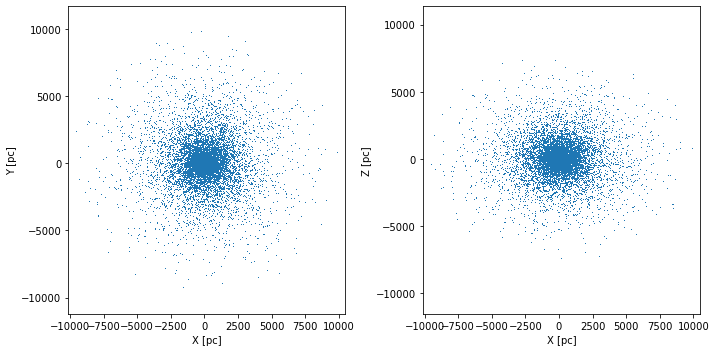

In [120]:
# Plotting Y versus X, and Z versus X, showing the slight flattening as short axis is along z which is revolution axis
fig = plt.figure(1, figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.plot(myMGE.x, myMGE.y, ',')
ax1.set_aspect('equal', 'datalim')
ax1.set_xlabel("X [pc]")
ax1.set_ylabel("Y [pc]")
ax2 = fig.add_subplot(122)
ax2.plot(myMGE.x, myMGE.z, ',')
ax2.set_aspect('equal', 'datalim')
ax2.set_xlabel("X [pc]")
ax2.set_ylabel("Z [pc]")
plt.tight_layout()

The spread along Z axis is inbetween [-7500,7500] [pc] but between [-10000,10000][pc] for X and Y


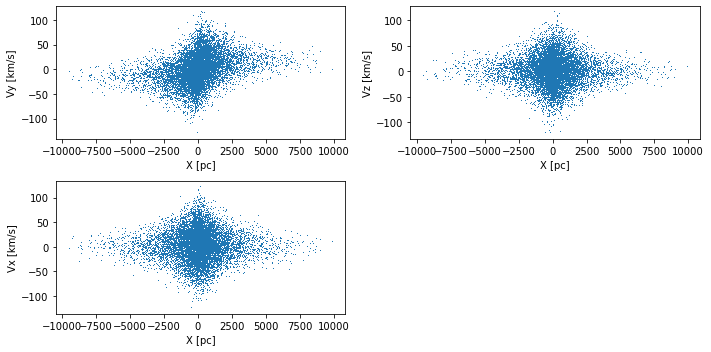

In [121]:
# Plotting Vx versus X, and Vy versus X, showing the slight flattening
fig = plt.figure(1, figsize=(10,5))
ax1 = fig.add_subplot(221)
ax1.plot(myMGE.x, myMGE.Vy, ',')
ax1.set_xlabel("X [pc]")
ax1.set_ylabel("Vy [km/s]")
ax2 = fig.add_subplot(222)
ax2.plot(myMGE.x, myMGE.Vz, ',')
ax2.set_xlabel("X [pc]")
ax2.set_ylabel("Vz [km/s]")
ax3 = fig.add_subplot(223)
ax3.plot(myMGE.x, myMGE.Vx, ',')
ax3.set_xlabel("X [pc]")
ax3.set_ylabel("Vx [km/s]")
plt.tight_layout()

On the top left plot, there is an asymetry along the x axis. Particles for X>0 are on average going towards Y>0 while particles for x<0 are going on average towards Y<0 : there is a global rotation of ~10 [km/s] around Z 

## Use of the model to compute LOSVDs

In [135]:
## Import the histogram functionalities
from pygme.pyhist import comp_losvd
## Number of points in the Velocity direction
nv = 101
maxV = 1000.0 ## in km/s, maximum velocity for the LOSVDs
## Number of point in the X and Y direction (the total number will be nXY * nXY)
## You can also specify a tupple for different numbers in X and Y
nXY = 101 
scaleR = 5000.0 # in parsec
## Compute the LOSVDs
losVz_xz =  comp_losvd(myMGE.x, myMGE.z, myMGE.Vz, weights=myMGE.BodMass, \
                  limXY=[-scaleR, scaleR, -scaleR, scaleR], nXY=nXY, limV=[-maxV,maxV], nV=nv)
losVy_xz =  comp_losvd(myMGE.x, myMGE.z, myMGE.Vy, weights=myMGE.BodMass, \
                  limXY=[-scaleR, scaleR, -scaleR, scaleR], nXY=nXY, limV=[-maxV,maxV], nV=nv)
losVx_yz =  comp_losvd(myMGE.y, myMGE.z, myMGE.Vx, weights=myMGE.BodMass, \
                  limXY=[-scaleR, scaleR, -scaleR, scaleR], nXY=nXY, limV=[-maxV,maxV], nV=nv)
losxr =  comp_losvd(myMGE.x[0:-1], myMGE.z[0:-1], myMGE.Vy[0:-1], weights=myMGE.BodMass[0:-1], \
                  limXY=[-scaleR, scaleR, -scaleR, scaleR], nXY=nXY, limV=[-maxV,maxV], nV=nv)
#for test
imageSize= 20
imageDepth= nv - 1
nlow = int(nXY/2 - imageSize/2)
nhigh =int(nXY/2 + imageSize/2)
nvlow = int((nv-1)/2 - imageDepth/2)
nvhigh =int((nv-1)/2 + imageDepth/2 + 1) 

res = losxr.losvd[nlow:nhigh,nlow:nhigh,nvlow:nvhigh]
#SAVE SOME RESULTS
np.save("./pygme_check_data", res)
np.save("./pygme_check_data", res)

(101, 101, 101)
5144189.054994007


/home/fraison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


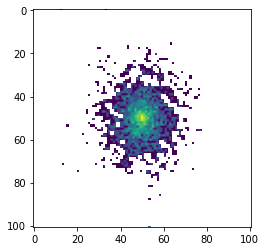

In [123]:
print(losVy_xz.losvd.shape)
print(np.max(losVy_xz.losvd))

plt.imshow(np.log10(np.max(losVy_xz.losvd, axis=2) ))



The maxima of the LOSVD are close to the center of the galaxy

(-200.0, 200.0)

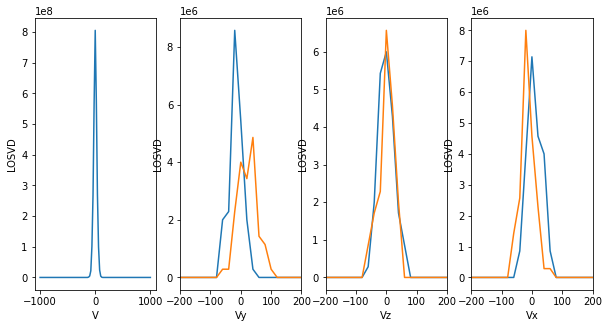

In [133]:
## PLotting some LOSVD. Here the sum of all computed LOSVDs
rlos = np.linspace(-maxV, maxV, nv)
sumLOSVD = losVz_xz.losvd.sum(axis=(0,1))
sumLOSVD_Vy = losVy_xz.losvd.sum(axis=(1,0))

fig = plt.figure(1, figsize=(10,5))
ax1 = fig.add_subplot(141)
ax1.plot(rlos, sumLOSVD)
ax1.set_xlabel("V")
ax1.set_ylabel("LOSVD")
ax2 = fig.add_subplot(142)
ax2.plot(rlos, losVy_xz.losvd.sum(axis=1)[30])
ax2.plot(rlos, losVy_xz.losvd.sum(axis=1)[70])
ax2.set_xlabel("Vy")
ax2.set_ylabel("LOSVD")
ax2.set_xlim([-200,200])
ax3 = fig.add_subplot(143)
ax3.plot(rlos, losVz_xz.losvd.sum(axis=1)[30])
ax3.plot(rlos, losVz_xz.losvd.sum(axis=1)[70])
ax3.set_xlabel("Vz")
ax3.set_ylabel("LOSVD")
ax3.set_xlim([-200,200])
ax4 = fig.add_subplot(144)
ax4.plot(rlos, losVx_yz.losvd.sum(axis=1)[30])
ax4.plot(rlos, losVx_yz.losvd.sum(axis=1)[70])
ax4.set_xlabel("Vx")
ax4.set_ylabel("LOSVD")
ax4.set_xlim([-200,200])


On the middle plot, we see again the asymetry of the velocity distribution due to the rotation around Z. No asymetry is visible on the third plot as there is no rotation around X. We should have quite similar distributions for Vy and Vx.

### Gauss Hermite fitting

In [125]:
# You can also fit a Gauss-Hermite function on this one
from pygme.fitting import fitGaussHermite
bestR, result, GHbest = fitGaussHermite.fitGH_mpfit(rlos, sumLOSVD, degGH=4)

------ Starting the minimisation -------
Chi2 =  7013736507391610.0
Chi2 =  619537393077082.6
Chi2 =  571142388098006.9
Chi2 =  570451175707592.1
Chi2 =  570438328991607.9
Chi2 =  570438089020965.2
Chi2 =  570438084535868.1
Chi2 =  570438084452691.2
=====
FIT: 
        I         V         Sig   
   784966975.493     0.143     26.869 
GH 03:  -0.0024 
GH 04:   0.0498 
Chi2:  570438084451305.2  Reduced Chi2:  5647901826250.547


/home/fraison/anaconda3/lib/python3.6/site-packages/pygme/fitting/mpfit.py:2268: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if numpy.rank(rr) != 2:


[ 7.84966975e+08  1.43408589e-01  2.68688362e+01 -2.41653580e-03
  4.98498064e-02]


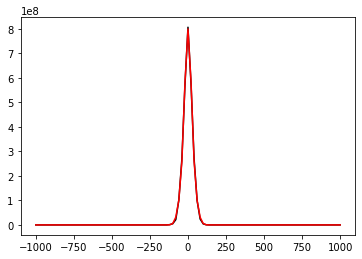

In [126]:
print(bestR)
plt.plot(rlos, sumLOSVD, 'k-')
plt.plot(rlos, GHbest, 'r-')

In [127]:
import scipy.stats as stats
# another try on a double peaked distribution
dbpeaked = stats.norm.pdf(rlos,0,25)+stats.norm.pdf(rlos,250,10)
bestR, result, GHbest = fitGaussHermite.fitGH_mpfit(rlos, dbpeaked, degGH=4)

------ Starting the minimisation -------
Chi2 =  0.007634955999619069
Chi2 =  0.005331053650751382
Chi2 =  0.005197593671060069
Chi2 =  0.005190830586161439
Chi2 =  0.005188831322454081
Chi2 =  0.005186984974422207
Chi2 =  0.00518539609996549
Chi2 =  0.00517982717454147
Chi2 =  0.0051766185037127104
Chi2 =  0.005173001077293615
Chi2 =  0.005169084450162553
Chi2 =  0.005150026918677357
Chi2 =  0.005127251490864426
Chi2 =  0.005067354320934246
Chi2 =  0.005064084488908951
Chi2 =  0.00506403066073108
Chi2 =  0.0050637475105821065
Chi2 =  0.005063743193999573
Chi2 =  0.005063742581616286
Chi2 =  0.005063740796140398
Chi2 =  0.005063740773674698
Chi2 =  0.0050637407656166575
Chi2 =  0.005063740753219895
Chi2 =  0.005063740753126852
Chi2 =  0.0050637407528598705
=====
FIT: 
        I         V         Sig   
      0.023   155.035    137.310 
GH 03:  -0.2000 
GH 04:  -0.2000 
Chi2:  0.005063740752883228  Reduced Chi2:  5.013604705824978e-05


/home/fraison/anaconda3/lib/python3.6/site-packages/pygme/fitting/mpfit.py:2268: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if numpy.rank(rr) != 2:


[ 2.26893490e-02  1.55035489e+02  1.37310283e+02 -2.00000000e-01
 -2.00000000e-01]


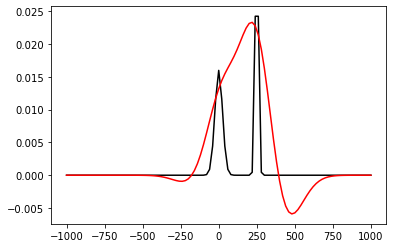

In [128]:
print(bestR)
plt.plot(rlos, dbpeaked, 'k-')
plt.plot(rlos, GHbest, 'r-')

### Mapping

/home/fraison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


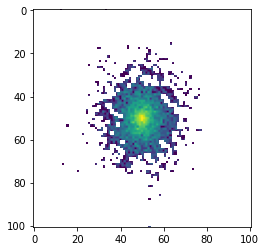

In [129]:
# Of course too few particles to have a complete mapping
plt.imshow(np.log10(losVz_xz.losvd.sum(axis=2)))